In [1]:
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import datetime as dt
import seaborn as sns
from sklearn.cluster import KMeans

from src import config

In [2]:
# customers = pd.read_csv(config.RAW_FILE_PATH / 'olist_customers_dataset.csv')
# orders = pd.read_csv(config.RAW_FILE_PATH / 'olist_orders_dataset.csv')
# order_items = pd.read_csv(config.RAW_FILE_PATH / 'olist_order_items_dataset.csv')

# for df in [order_items, customers, orders]: 
#     print(df.info())

# rfm_order_items = order_items.groupby('order_id').agg({'price': sum, 'freight_value': sum, 'shipping_limit_date': max}).reset_index() 

# rfm_orders = orders.merge(rfm_order_items, on='order_id', how='inner')

# rfm = customers.merge(rfm_orders, on='customer_id', how='inner')

# rfm['order_status'].value_counts()

# rfm = rfm.loc[rfm['order_status'] == 'delivered']

# datetime_cols = [
#   'order_purchase_timestamp',
#   'order_approved_at',
#   'order_delivered_carrier_date',
#   'order_delivered_customer_date',
#   'order_estimated_delivery_date',
# ]

# for col in datetime_cols: 
#     rfm[col] = pd.to_datetime(rfm[col])

# rfm.info()

# rfm = rfm.dropna(axis=0)

# max_date = max(rfm['order_purchase_timestamp']) + dt.timedelta(days=1)

# rfm = rfm.groupby('customer_unique_id').agg({
#     'order_purchase_timestamp': lambda x: (max_date - x.max()).days,
#     'customer_id': 'count',
#     'price': sum
# }).reset_index()

# rfm.columns = ['customer_unique_id', 'recency', 'frequency', 'monetary']

# rfm.describe()

# rfm.to_csv(config.INT_FILE_PATH / 'rfm.csv')

In [3]:
### scoring

In [4]:
rfm = pd.read_parquet(config.INT_FILE_PATH / "rfm.parquet")

In [5]:
rfm.describe()

,recency,frequency,monetary
count,93336.000000,93336.000000,93336.000000
mean,237.903853,1.033417,141.621663
std,152.552964,0.209098,215.714143
min,1.000000,1.000000,0.850000
25%,114.000000,1.000000,47.650000
50%,219.000000,1.000000,89.700000
75%,346.000000,1.000000,154.692500
max,714.000000,15.000000,13440.000000


In [6]:
rfm.columns

Index(['customer_unique_id', 'recency', 'frequency', 'monetary'], dtype='object')

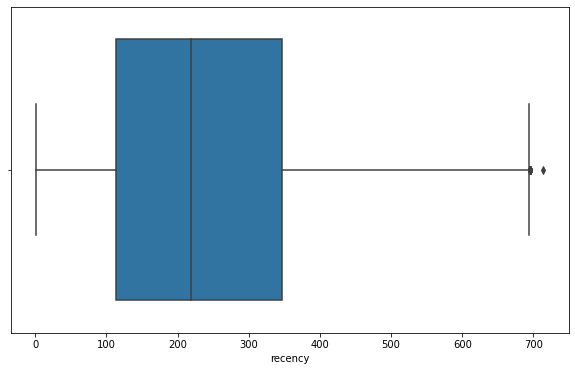

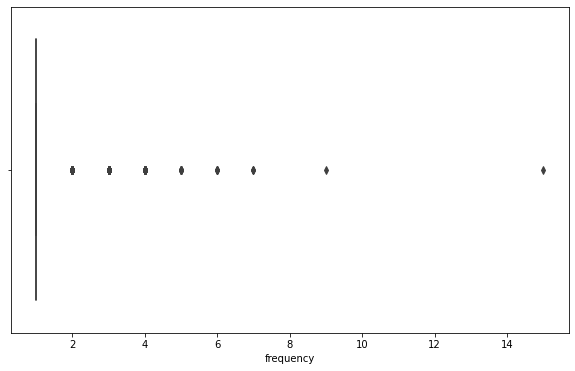

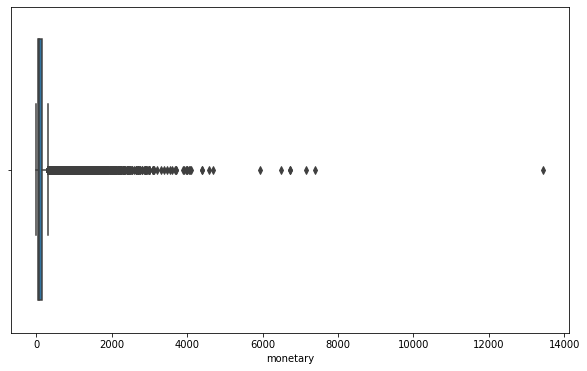

In [7]:
for col in ["recency", "frequency", "monetary"]:
    fig, _ = plt.subplots(figsize=(10,6))
    sns.boxplot(x=rfm[col])
    plt.show()

In [8]:
def get_cluster_score(data, column, invert=False):
    data = data
    class_score = f"{column}_score"
    X = pd.DataFrame(data[column])
    
    kmeans_kwargs = {
        "n_clusters": 4,
        "init": "random",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 1,
    }

    def sorted_cluster(x, model=None):
        if model == None:
            model = KMeans()
        model = sorted_cluster_centers_(model, x)
        model = sorted_labels_(model, x)
        return model

    def sorted_cluster_centers_(model, x):
        model.fit(x)
        new_centroids = []
        magnitude = []
        for center in model.cluster_centers_:
            magnitude.append(np.sqrt(center.dot(center)))
        idx_argsort = np.argsort(magnitude)
        model.cluster_centers_ = model.cluster_centers_[idx_argsort]
        return model

    def sorted_labels_(sorted_model, x):
        sorted_model.labels_ = sorted_model.predict(x)
        return sorted_model


    km = KMeans(**kmeans_kwargs).fit(X)
    cluster = sorted_cluster(X, km)
    X[class_score] = cluster.predict(X)


    plt.figure(figsize=(15,3))
    plt.title(f'Results of clustering {column}')

    sns.scatterplot(x=X[column], y=X.index, hue=X[class_score], s=10,)
    
    # append back to original dataset
    data[class_score] = X[class_score] + 1

    if invert:
        data[class_score] = data[class_score].map({4:1, 3:2, 2:3, 1:4})


In [9]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93336 entries, 0 to 93335
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93336 non-null  object 
 1   recency             93336 non-null  int64  
 2   frequency           93336 non-null  int64  
 3   monetary            93336 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.8+ MB


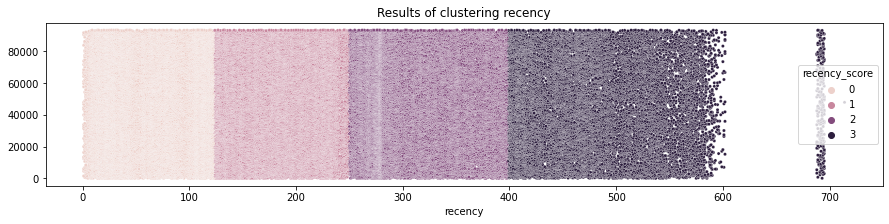

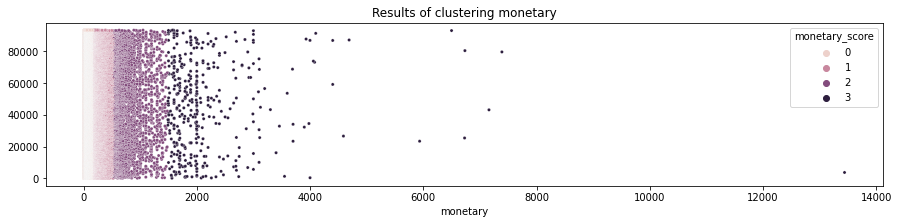

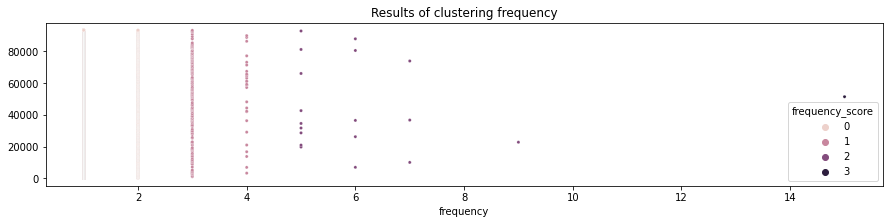

In [10]:
# make scores 
get_cluster_score(rfm, "recency", invert=True)
get_cluster_score(rfm, "monetary")
get_cluster_score(rfm, "frequency")

In [11]:
rfm["total_score"] = rfm["recency_score"] + rfm["monetary_score"] + rfm["frequency_score"] 

In [12]:
rfm["segment_value"] = pd.cut(rfm["total_score"], bins=3, labels=["Low", "Medium", "High"])

In [13]:
rfm.head()

,customer_unique_id,recency,frequency,monetary,recency_score,monetary_score,frequency_score,total_score,segment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,1,6,Medium
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,6,Medium
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,1,3,Low
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,4,Low
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,2,1,5,Low
